In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.1 MB/s eta 0:00:00


In [2]:
import gensim.downloader
import torch
import torch.nn as nn
import torch.optim as optim
from datasets import load_dataset
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
# Load the dataset
dataset = load_dataset("eriktks/conll2003")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for eriktks/conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/eriktks/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [4]:
# Load the model
word2vec_model = gensim.downloader.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [5]:
# Define vocabulary and tag mappings
vocab = {"<PAD>": 0, "<UNK>": 1}
vocab.update({word: (idx + 2 if word in word2vec_model.key_to_index else 1)
              for idx, word in enumerate(set(word for example in dataset["train"]["tokens"] for word in example))})

tag_map = {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG',
           5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}

In [6]:
# Create embedding matrix
embedding_dim = word2vec_model.vector_size
embedding_matrix = torch.zeros((len(vocab), embedding_dim))

for word, idx in vocab.items():
    if word in word2vec_model.key_to_index:
        embedding_matrix[idx] = torch.tensor(word2vec_model[word])
    else:
        embedding_matrix[idx] = torch.randn(embedding_dim)

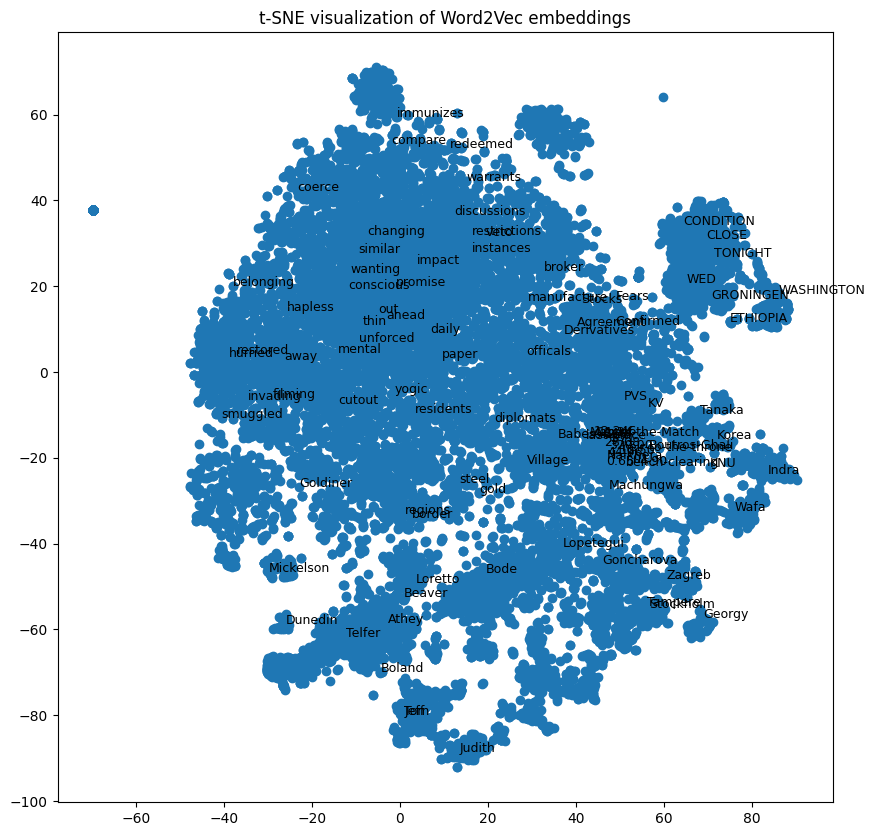

In [7]:
words = list(vocab.keys())[2:]  # Exclude "<PAD>" and "<UNK>"
word_embeddings = embedding_matrix[2:].detach().numpy()  # Exclude the embeddings for "<PAD>" and "<UNK>"

pca = PCA(n_components=50)
pca_result = pca.fit_transform(word_embeddings)

tsne = TSNE(n_components=2, random_state=0)
tsne_result = tsne.fit_transform(pca_result)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], marker='o')

for i, word in enumerate(words[:100]):
    plt.annotate(word, (tsne_result[i, 0], tsne_result[i, 1]), fontsize=9)

plt.title('t-SNE visualization of Word2Vec embeddings')
plt.show()

In [8]:
# CNN model for NER
class CNNER(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, num_classes, pretrained_embeddings):
        super(CNNER, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=False, padding_idx=0)
        self.conv1 = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, fs, padding=fs//2) for fs in filter_sizes
        ])
        self.conv2 = nn.ModuleList([
            nn.Conv1d(num_filters, num_filters, fs, padding=fs//2) for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)  # (batch, embed_dim, seq_len)
        # First convolutional pass + ReLU
        conv_outputs = [F.relu(conv(x)) for conv in self.conv1]
        # Second convolutional pass
        conv_outputs = [F.relu(conv(c)) for conv, c in zip(self.conv2, conv_outputs)]
        x = torch.cat(conv_outputs, dim=1)
        x = x.transpose(1, 2)  # (batch, seq_len, num_filters * len(filter_sizes))
        return self.fc(x)  # (batch, seq_len, num_classes)

In [9]:
# Hyperparameters
NUM_FILTERS = 100
FILTER_SIZES = [3, 5, 7]
NUM_CLASSES = 9
BATCH_SIZE = 32
EPOCHS = 100

In [10]:
# Prepare data
def prepare_sequence(seq, to_ix):
    return torch.tensor([to_ix.get(w, to_ix["<UNK>"]) for w in seq], dtype=torch.long)

def collate_fn(batch):
    tokens = [prepare_sequence(example['tokens'], vocab) for example in batch]
    tags = [torch.tensor(example['ner_tags'], dtype=torch.long) for example in batch]

    tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=0)
    tags_padded = pad_sequence(tags, batch_first=True, padding_value=-1)

    return tokens_padded, tags_padded

In [11]:
train_loader = DataLoader(dataset['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(dataset['test'], batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [12]:
# Initialize model, loss, and optimizer
model = CNNER(len(vocab), embedding_dim, NUM_FILTERS, FILTER_SIZES, NUM_CLASSES, embedding_matrix)
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(),lr=0.00001)

In [13]:
# Validation function
def validate_input(input_tensor, num_embeddings):
    if torch.any(input_tensor < 0) or torch.any(input_tensor >= num_embeddings):
        raise ValueError(f"Input tensor contains invalid indices. Valid range: [0, {num_embeddings-1}]")
    return input_tensor.long()

In [14]:
# Evaluation function
def evaluate(loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            inputs, targets = batch
            inputs = validate_input(inputs, len(vocab))
            outputs = model(inputs)
            loss = criterion(outputs.view(-1, NUM_CLASSES), targets.view(-1))
            total_loss += loss.item()
            preds = outputs.argmax(dim=2)
            mask = targets != -1
            all_preds.extend(preds[mask].view(-1).tolist())
            all_labels.extend(targets[mask].view(-1).tolist())
    avg_loss = total_loss / len(loader)
    return avg_loss, classification_report(all_labels, all_preds, target_names=list(tag_map.values()), zero_division=0)

In [15]:
# Training loop with validation
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs = validate_input(inputs, len(vocab))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, NUM_CLASSES), targets.view(-1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validate after each epoch
    val_loss, val_report = evaluate(val_loader)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print("Validation Performance:")
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    print(val_report)
    print("-" * 50)

Epoch 1/100
Training Loss: 1.2249
Validation Loss: 1.0318
Validation Performance:
              precision    recall  f1-score   support

           O       0.83      1.00      0.91     42759
       B-PER       0.00      0.00      0.00      1842
       I-PER       0.00      0.00      0.00      1307
       B-ORG       0.00      0.00      0.00      1341
       I-ORG       0.00      0.00      0.00       751
       B-LOC       0.00      0.00      0.00      1837
       I-LOC       0.00      0.00      0.00       257
      B-MISC       0.00      0.00      0.00       922
      I-MISC       0.00      0.00      0.00       346

    accuracy                           0.83     51362
   macro avg       0.09      0.11      0.10     51362
weighted avg       0.69      0.83      0.76     51362

--------------------------------------------------
Epoch 2/100
Training Loss: 0.7846
Validation Loss: 0.8140
Validation Performance:
              precision    recall  f1-score   support

           O       0.83  

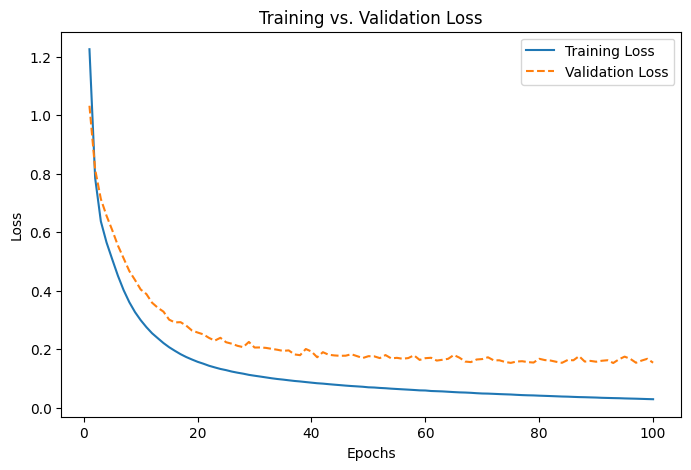

In [16]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

In [17]:
# Evaluate on test set
try:
    test_loss, test_report = evaluate(test_loader)
    print("Test Set Performance:")
    print(f"Test Loss: {test_loss:.4f}")
    print(test_report)
except ValueError as e:
    print(f"Error during evaluation: {e}")

Test Set Performance:
Test Loss: 0.2604
              precision    recall  f1-score   support

           O       0.96      0.99      0.97     38323
       B-PER       0.92      0.67      0.78      1617
       I-PER       0.95      0.70      0.80      1156
       B-ORG       0.85      0.68      0.75      1661
       I-ORG       0.84      0.65      0.73       835
       B-LOC       0.89      0.84      0.86      1668
       I-LOC       0.83      0.63      0.71       257
      B-MISC       0.77      0.72      0.75       702
      I-MISC       0.68      0.61      0.64       216

    accuracy                           0.94     46435
   macro avg       0.85      0.72      0.78     46435
weighted avg       0.94      0.94      0.94     46435



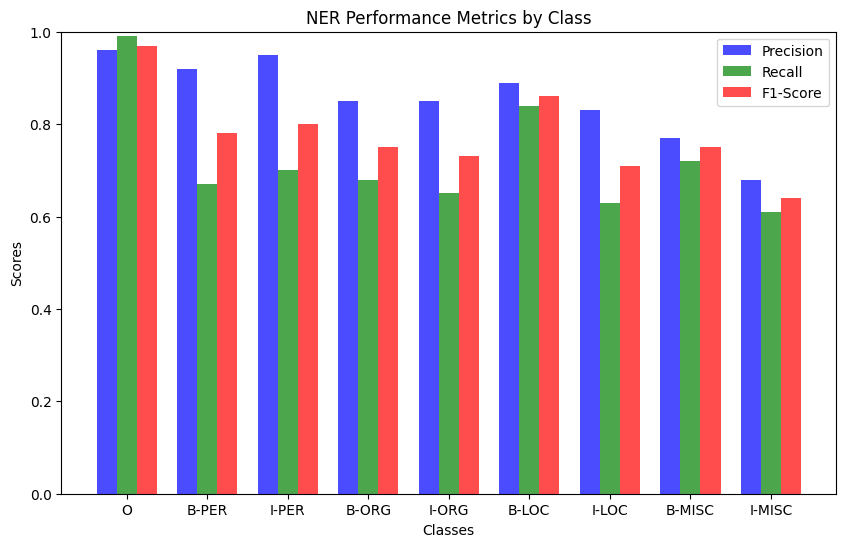

In [1]:
classes = ["O", "B-PER", "I-PER", "B-ORG", "I-ORG", "B-LOC", "I-LOC", "B-MISC", "I-MISC"]
precision = [0.96, 0.92, 0.95, 0.85, 0.85, 0.89, 0.83, 0.77, 0.68]
recall = [0.99, 0.67, 0.70, 0.68, 0.65, 0.84, 0.63, 0.72, 0.61]
f1_score = [0.97, 0.78, 0.80, 0.75, 0.73, 0.86, 0.71, 0.75, 0.64]

bar_width = 0.25
x = np.arange(len(classes))

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, precision, width=bar_width, label="Precision", color="blue", alpha=0.7)
plt.bar(x, recall, width=bar_width, label="Recall", color="green", alpha=0.7)
plt.bar(x + bar_width, f1_score, width=bar_width, label="F1-Score", color="red", alpha=0.7)

plt.xlabel("Classes")
plt.ylabel("Scores")
plt.title("NER Performance Metrics by Class")
plt.xticks(ticks=x, labels=classes)
plt.legend()
plt.ylim(0, 1)

plt.show()
